# Machine Learning in Python - Workshop 9

In this week's workshop we will be returning to the NYC Parking Ticket data and exploring how to score and evaluate multiclass classification models as well as trying several addition modeling approaches for this type of data. 

# 1. Setup


## 1.1 Packages


In the cell below we will load the core libraries we will be using for this workshop and setting some sensible defaults for our plot size and resolution. 

In [ ]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble 
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline

## 1.2 Helper Functions



In [ ]:
def plot_boundaries(bounds, x='lon', y='lat', group='precinct', n=5):
    """ Draws boundary lines for a series of groups polygons in a dataframe
    """
    sns.lineplot(x=x, y=y, hue=group, data=bounds,
                 sort=False, palette=['k']*n, legend=None)

In [ ]:
def plot_pred_labels(res, pred = 'pred_label', truth = 'precinct'):
    """ Plots the predicted labels and true labels from a common data frame
    """
    plt.figure(figsize=(5,8))
    
    ax = sns.scatterplot(
        x='lon', y='lat', hue=pred, palette=precinct_pal, data=res
    )
    plot_boundaries(manh_bounds)
    
    acc = sklearn.metrics.accuracy_score(
        res[truth], res[pred]
    )
    
    ax.set_title("Predicted Labels (Accuracy {:.3f})".format(acc))
    
    plt.show()

## 1.3 Data

As described in the Week 7 workshop, these data comes from New York City's [Open Data project](https://opendata.cityofnewyork.us/). We have simplified the data somewhat and restricted the data to just include the five precincts (1st, 5th, 6th, 7th, and 9th) in the southern end of Manhattan. The following data files have been provided:

* `manh_tickets.csv` - Geocoded parking tickets from the 5 southern most precincts in Manhattan
* `manh_test.csv` - Points randomly sampled within the true boundaries of these precincts
* `manh_bounds.csv` - boundaries of these precincts

As before, our goal is to use these parking tickets to develop a model which correctly predicts the boundaries of the police precincts in Manhattan based only on the locations where parking tickets have been issued. We will read in all the data sets using pandas,

In [ ]:
manh_tickets = pd.read_csv("manh_tickets.csv")
manh_test    = pd.read_csv("manh_test.csv")
manh_bounds  = pd.read_csv("manh_bounds.csv")

and create our basic response vector and model matrix,

In [ ]:
X = manh_tickets[['lon','lat']]
y = manh_tickets.precinct

Finally, we create labels and a color palette which will be used for across subsequent plots.

In [ ]:
precincts = ['Precinct01', 'Precinct05', 'Precinct06', 'Precinct07', 'Precinct09']
precincts_short = ['P01', 'P05', 'P06', 'P07', 'P09']
precincts_pred = ["pred_" + p for p in precincts_short]

# Create a color palette for precincts based on the cols25 palette from R's pals package
precinct_pal = dict(
    zip(precincts,
        [(0.1215686, 0.47058824, 0.7843137), (1.0000000, 0.00000000, 0.0000000),
         (0.2000000, 0.62745098, 0.1725490), (0.4156863, 0.20000000, 0.7607843),
         (1.0000000, 0.49803922, 0.0000000) ]
    )
)

Using our new palette we can plot the original parking ticket data and add the precinct boundaries using `plot_boundaries` to make everything more readable.

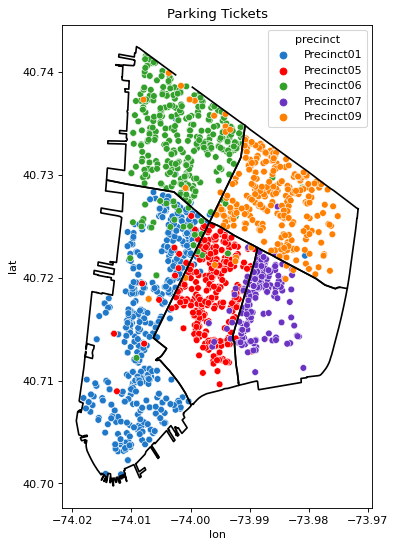

In [ ]:
plt.figure(figsize=(5,8))

sns.scatterplot(
    x='lon', y='lat', hue='precinct', palette=precinct_pal, data=manh_tickets
).set_title("Parking Tickets")
plot_boundaries(manh_bounds)

plt.show()

--- 

# 1.4. Review - Multiclass logistic (multinomial) regression 



At the end of the Week 7 workshop we had fit a Logistic Regression model using `multi_class=multinomial` in order to obtain a probabilistically consistent predictive model, e.g. for any given prediction the probabilities of each class sum to one. We will begin by reconstructing this same model and using it as a point of comparison.

In [ ]:
m_mn = make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(penalty='none', multi_class='multinomial')
).fit(X, y)

This model is then used to predict both the class label for test location as well as the predicted probability for each precinct for all test locations, these results are then stored in the `res_mn` data frame.

In [ ]:
res_mn = pd.concat(
    [ manh_test,
      pd.Series(
          data = m_mn.predict(manh_test[['lon','lat']]),
          name = "pred_label"
      ),
      pd.DataFrame(
          data = m_mn.predict_proba(manh_test[['lon','lat']]),
          columns = precincts_pred
      )
    ], 
    axis = 1
)

res_mn


,precinct,lon,lat,pred_label,pred_P01,pred_P05,pred_P06,pred_P07,pred_P09
0,Precinct01,-74.010330,40.720485,Precinct01,0.996715,0.002760,5.245982e-04,2.601684e-08,6.066956e-09
1,Precinct01,-74.005740,40.708015,Precinct01,0.878555,0.121173,1.312997e-07,2.714364e-04,1.333554e-09
2,Precinct01,-74.001993,40.707750,Precinct05,0.465160,0.523614,2.073632e-07,1.122583e-02,4.409586e-08
3,Precinct01,-74.005499,40.706179,Precinct01,0.837832,0.161541,3.234373e-08,6.272248e-04,6.308147e-10
4,Precinct01,-74.009585,40.726523,Precinct01,0.926785,0.001993,7.122160e-02,7.586284e-09,3.263365e-07
...,...,...,...,...,...,...,...,...,...
2495,Precinct09,-73.993883,40.725202,Precinct05,0.030168,0.439143,1.913318e-01,2.258760e-02,3.167692e-01
2496,Precinct09,-73.988460,40.729783,Precinct09,0.000017,0.002933,2.501241e-02,1.313258e-03,9.707246e-01
2497,Precinct09,-73.984370,40.725988,Precinct09,0.000001,0.002990,3.716451e-04,3.438030e-02,9.622564e-01
2498,Precinct09,-73.989221,40.723938,Precinct09,0.000641,0.140995,7.625062e-03,1.483359e-01,7.024028e-01


---

### &diams; Exercise 1

Pick at least three random test locactions and using `res_mn` verify that the predicted label for each point corresponds to the class with the largest predicted probability and that the predicted probabilities are consistent (e.g. they add up to 1).

In [ ]:
print( "Row sums:\n", res_mn.head()[precincts_pred].sum(axis = 1), "\n" )
print( "Pred Labels:\n", res_mn.head()["pred_label"], "\n" )
print( "Max col:\n", res_mn.head()[precincts_pred].idxmax(axis=1), "\n" )

Row sums:
 0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64 

Pred Labels:
 0    Precinct01
1    Precinct01
2    Precinct05
3    Precinct01
4    Precinct01
Name: pred_label, dtype: object 

Max col:
 0    pred_P01
1    pred_P01
2    pred_P05
3    pred_P01
4    pred_P01
dtype: object 



---

We can also use the `plot_pred_labels` function, defined witht the helper functions above, to visualize the predicted labels.

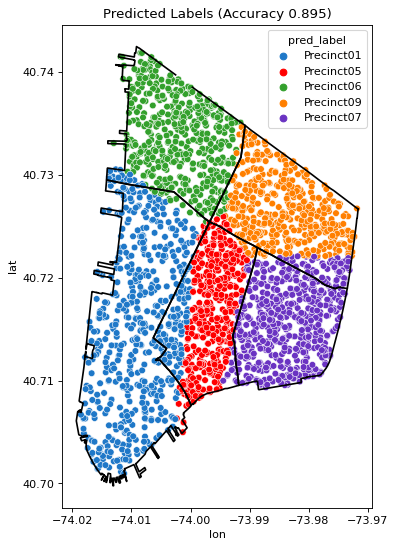

In [ ]:
plot_pred_labels(res_mn)

---

# 2. Additional scoring methods / tools for multiclass models


## 2.1 Confusion Matrix

As we saw in week 7, perhaps the most straight forward approach to assess a model is to use the label predictions directly to construct a confusion matrix which places the true labels along the rows and the predicted labels along the columns.

In [ ]:
sklearn.metrics.confusion_matrix(res_mn.precinct, res_mn.pred_label)

array([[473,  15,  12,   0,   0],
       [ 86, 379,   0,  27,   8],
       [ 19,   0, 476,   0,   5],
       [  0,   0,   0, 496,   4],
       [  0,   7,  10,  69, 414]])

---

### &diams; Exercise 4

Explain what information is given by the value 27 given in the 2nd row, 5th column of this confusion matrix.

*This value corresponds to the 27 test locations that belong to Precinct 5 but were incorrectly classified as Precinct 9*

---

To expand on this idea, and to help scale this approach to cases when there are many classes sklearn provides a convenient plotting function for visualizing the confusion matrix which provides methods for normalizing by the rows ("true"), columns ("pred"), or all values.

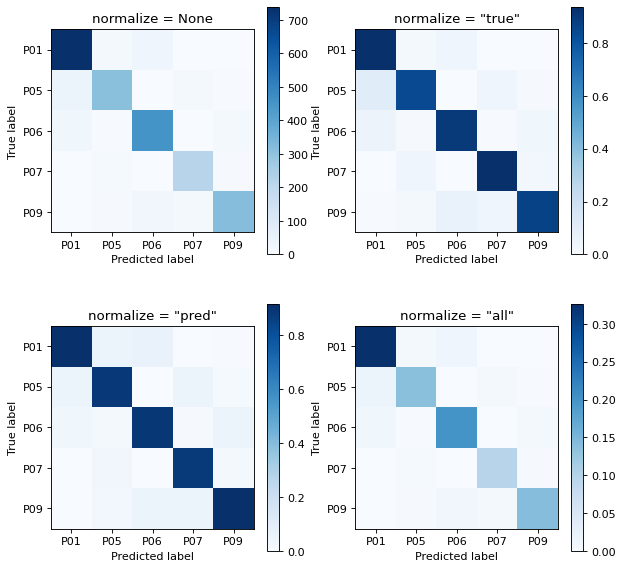

In [ ]:
fig = plt.figure(figsize=(9, 9))
normalize=[None, 'true', 'pred', 'all']

for i in range(len(normalize)):
    ax = fig.add_subplot(221+i)
    
    if (normalize[i] is None):
        ax.set_title("normalize = None")
    else:
        ax.set_title("normalize = \"" + normalize[i] + "\"")
    
    sklearn.metrics.plot_confusion_matrix(
        m_mn, X, y, include_values=False, ax=ax,
        normalize = normalize[i],
        display_labels = precincts_short,
        cmap = plt.cm.Blues
    )


---

### &diams; Exercise 2

Which normalization method appears to be is most useful for determining False Positives, what about False Negatives? Explain.

*Given that this model performs well it is a bit hard to see the differences, but generally since `true` normalizes over the rows and is therefore useful for comparing False Positive rates, while `pred` normalizes over the columns and is therefore useful for comparing False Negative rates.*

---

## 2.2 One-vs-rest ROC curves

Previously in the case of logistic regression (binary classification) we saw how this enabled us to consider all possible decision threshold values to generate a receiver operating characteristic (ROC) curve showing the trade off between possible true positive and false positive rates.

In the case of a classification model that produces probabilistic predictions we can extend this idea to the multiclass case but it is not without some significant drawbacks. Specifically, the concept of a decision threshold does not make sense in the multiclass setting since we need to make a choice among $k$ classes. However, what we can do is consider a one-vs-rest approach where we take each class as the positive case and all other classes as the negative. In this way we can construct $k$ different ROC curves using our original predicted probabilities. The function below implements this considering each class separately and calculating a unique ROC and AUC for each. 

In [ ]:
def ovr_roc_plot(y_true, y_pred):
    """ Draw ROC curves using one-vs-rest approach
    """
    
    classes = y_true.unique()
    n_classes = len(y_true.unique())
    
    # Convert from n x 1 categorical matrix to n x k binary matrix
    y_true = pd.get_dummies(y_true).to_numpy()
    
    y_pred = y_pred.to_numpy()
    
    # Sanity Check
    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("Truth and prediction dimensions do not match.")
    
    # Compute ROC curve and ROC area for each class
    rocs = dict() 
    aucs = dict() 
    for name, i in zip(classes, range(n_classes)):
        aucs[i] = pd.DataFrame({ 
            'precinct': [name],
            'auc': [sklearn.metrics.roc_auc_score(y_true[:, i], y_pred[:, i])]
        })
        
        rocs[i] = pd.DataFrame(
            data = np.c_[sklearn.metrics.roc_curve(y_true[:, i], y_pred[:, i])],
            columns = ('fpr', 'tpr', 'threshold')
        ).assign(
            precinct = name
        )
    
    # Bind rows to create a single data frame for each
    roc = pd.concat(rocs, ignore_index=True)
    auc = pd.concat(aucs, ignore_index=True)
    
    # Create plot
    fig = plt.figure(figsize=(8, 8))
    sns.lineplot(x='fpr', y='tpr', hue='precinct', data=roc, ci=None, palette=precinct_pal)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.title("ROC (one-vs-rest) curves")
         
    L = plt.legend()
    for precinct, auc_val, i in zip(auc.precinct, auc.auc, range(n_classes)):
        L.get_texts()[i].set_text("{} (auc {:.3f})".format(precinct, auc_val))
        
    plt.show()
    
    # Return the AUCs as a Data Frame
    return(auc)

We can then use this function to evaluate our class probability predictions.

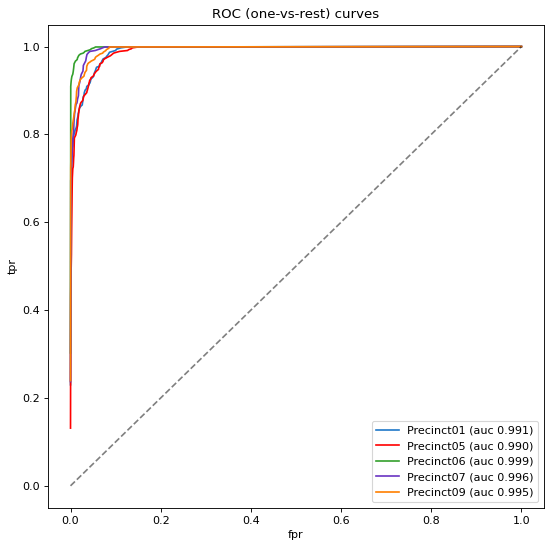

,precinct,auc
0,Precinct01,0.991378
1,Precinct05,0.989793
2,Precinct06,0.998792
3,Precinct07,0.995503
4,Precinct09,0.994983


In [ ]:
ovr_roc_plot(res_mn.precinct, res_mn[precincts_pred])

---

### &diams; Exercise 3

Does the ordering of the AUC values agree with your intuition about the models performance for the different precincts?

*Yes this ordering matches expectations from a visual inspection of the labels, Precinct 6 has the best performance while 1 and 5 have the worst. It differs somewhat from what might be taken from the confusion matrix - but keep in mind that the ROC / AUC is related to both the rows and the columns of that table.*

---

### &diams; Exercise 4

We have already established that this is reasonable for predicting most of these police precincts (accuracy of 0.895), however the AUCs reported for our model look very very good (all are >0.99). Can you explain this discrepancy? 

*Hint* - look at the definition of TPR and FPR and then think about what happens when we use the one-vs-rest approach. 

*The result here is overly optimistic due to the class imbalance that is implicit in the one-vs-rest approach. Given the classes are equally weight to begin, the ovr results in a 1 to 4 imbalance which then inflates the AUC (since we do very will based on the True Negative rate).*

---

# 3. Other multiclass classification models

For this section we will explore a number approaches to fitting and predict multiclass classification models. For the sake of uniformity we will assess the models in the same way:

* Plot all of the predicted labels and the true labels for a visual comparison and

* Show the `classification_report` result for the predicted labels.

To avoid repeated code we will use the following helper function,

In [ ]:
def model_test_assess(model, inc_report = True, inc_proba = False):
    # Use the model to predict test labels
    res = pd.concat(
        [ manh_test,
          pd.Series(
              data = model.predict(manh_test[['lon','lat']]),
              name = "pred_label"
          )
        ], 
        axis = 1
    )
        
    if (inc_proba):
        res = pd.concat(
            [ res, 
              pd.DataFrame(
                  data = model.predict_proba(manh_test[['lon','lat']]),
                  columns = precincts_pred
              )
            ], 
            axis = 1
        )
    
    # Plot labels
    plot_pred_labels(res)
    
    if inc_report: # Print report
        print(
            sklearn.metrics.classification_report(
                res.precinct, res.pred_label,
                zero_division = 0
            )
        )

## 3.1. Support Vector Machines

### 3.1.1 `SVC`

Standard Support Vector Classifier models are able to handle multiclass outcome vectors by fitting all of the one-to-one SVC models for each pair of classes. This therefore involves fitting ${k \choose 2} = k(k-1)/2$ SVC models which can be slow. The labels are predicted based on using all ${k \choose 2}$ generate binary predictions which are then tabulated and the label with the most votes is choosen. See [here](https://scikit-learn.org/stable/modules/svm.html#svm-classification) for more details.

Below we define a function for fitting and assess this model using different kernel and penalty values. As SVMs can be sensitive to scale of the features we include a pipeline thats scales the latitude and logitude values before fitting the model.

In [ ]:
def fit_svc(kernel, C):
    m_svc = make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.SVC(C=C, kernel=kernel)
    ).fit(X,y)
    
    model_test_assess(m_svc)

---

### &diams; Exercise 5

Using this function try different values of `kernel` and `C`, what seems to produce the best model? Explain why you think this model is performing better than the alternatives.

*Hint* - recommended kernels to try include `rbd`, `poly`, and `linear`.

In [ ]:
# Following not needed, but makes life easier
gs_svc = sklearn.model_selection.GridSearchCV(
    make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.SVC()
    ),
    [
        {
            "svc__kernel": ["linear", "rbf"],
            "svc__C": np.logspace(-2,2, num=30)
        },
        {
            "svc__kernel": ["poly"],
            "svc__degree": [1, 2, 3],
            "svc__C": np.logspace(-2,2, num=30)
        }
    ],
    cv = sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)
).fit(X,y)

In [ ]:
print( gs_svc.best_params_ )
print( gs_svc.best_score_ )

{'svc__C': 52.98316906283707, 'svc__kernel': 'rbf'}
0.9331858407079647


*If proper CV is done, we end up with an `rbf` model with `C=53` produces the best result. If just looking at test performance `linear` model with `C=10` produces a better test fit (there is a bit of overfitting here).*

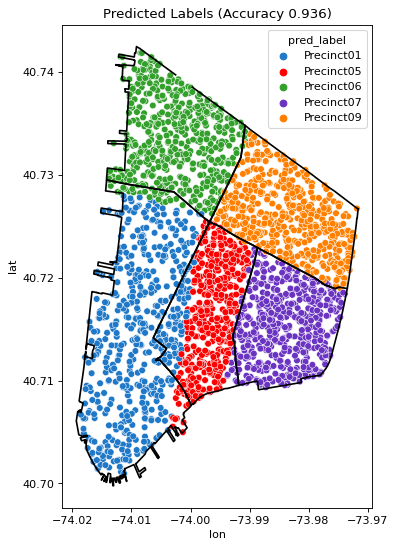

              precision    recall  f1-score   support

  Precinct01       0.85      0.91      0.88       500
  Precinct05       0.95      0.80      0.87       500
  Precinct06       0.94      1.00      0.97       500
  Precinct07       0.95      0.99      0.97       500
  Precinct09       0.99      0.98      0.98       500

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.93      2500
weighted avg       0.94      0.94      0.93      2500



In [ ]:
fit_svc(kernel = "linear", C=20)

---

### &diams; Exercise 6

Comment out the line of code that includes the `StandardScaler` in the pipeline below. What happens to the models predictive performance? Try adjusting `C` and or `kernel` to see if you can improve things.

*If this line is commented out the model completely breaks and cannot be fixed with different `C` or `kernel` values.*

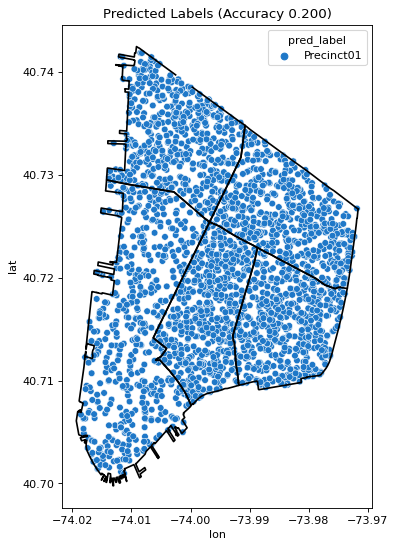

In [ ]:
m_svc2 = make_pipeline(
    #sklearn.preprocessing.StandardScaler(),
    sklearn.svm.SVC(C=1, kernel="linear")
).fit(X,y)

model_test_assess(m_svc2, inc_report=False)

---

### 3.1.2 `LinearSVC`

An alternative to the one-vs-one behavior of `SVC` is to instead fit a one-vs-rest model, in sklearn this is only supported by the `LinearSVC` classifier model. This modeling approach needs to only fit $k$ SVM models, and is therefore usually much faster for large $k$. However, due to implementation details of the underlying fitting library it does not support non-linear kernels. As with other SVM models it is important to scale our data before fitting.

In [ ]:
def fit_lsvc(C):
    m_lsvc = make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.LinearSVC(C=C, max_iter=5000)
    ).fit(X,y)
    
    model_test_assess(m_lsvc)

---

### &diams; Exercise 7

Using this function try different values of `C` to tune the model, how does its performance compare to the `SVC` model?

*This model produces worse performance than the previously examined SVC models (either rbd or linear).*

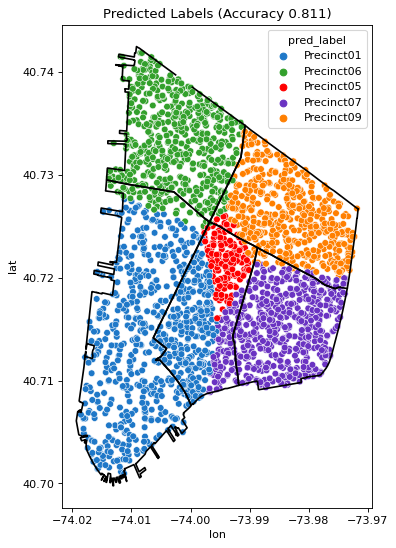

              precision    recall  f1-score   support

  Precinct01       0.64      0.92      0.75       500
  Precinct05       0.91      0.25      0.40       500
  Precinct06       0.90      1.00      0.95       500
  Precinct07       0.80      0.98      0.88       500
  Precinct09       0.96      0.91      0.94       500

    accuracy                           0.81      2500
   macro avg       0.84      0.81      0.78      2500
weighted avg       0.84      0.81      0.78      2500



In [ ]:
fit_lsvc(C=1)

## 3.2 Tree based methods

### 3.2.1 `DecisionTreeClassifier`

This model fits a decision tree model that attempts to classify observations by constructing a binary decision tree on the features provided. In the case of binary and multiclass classification the predicted label is based on the most common label within the terminal node. For fitting this model for these data we will solely focus on the use of the `max_depth` parameter which determines the number of branchs within the tree. Keep in mind that each additional layer added to the tree potentially increases the number of nodes by a factor of 2. 


In [ ]:
def fit_dt(max_depth):
    m_dt = sklearn.tree.DecisionTreeClassifier(
        max_depth = max_depth
    ).fit(X,y)
    
    model_test_assess(m_dt)

Use the following code chunk to explore the effect of different max depths on the tree model.

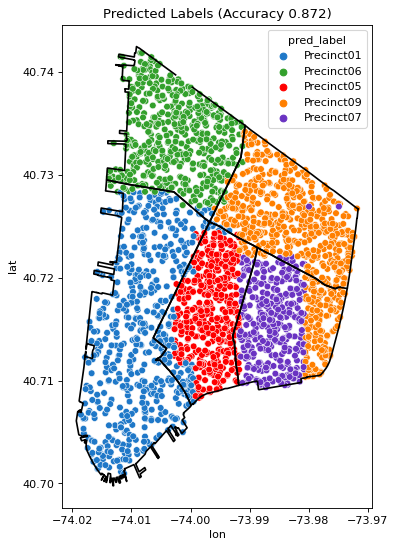

              precision    recall  f1-score   support

  Precinct01       0.86      0.97      0.91       500
  Precinct05       0.95      0.79      0.87       500
  Precinct06       0.97      0.98      0.98       500
  Precinct07       0.92      0.66      0.77       500
  Precinct09       0.73      0.96      0.83       500

    accuracy                           0.87      2500
   macro avg       0.89      0.87      0.87      2500
weighted avg       0.89      0.87      0.87      2500



In [ ]:
fit_dt(max_depth = 5)

---

### &diams; Exercise 8

Using `max_depth=1` how many different classes are reflected in the predictions? Using `max_depth=2`? Based on this and given there are 5 classes we are attempting to classify, what is the minimum depth of tree should we be using?

*`max_depth=1` only predicts 2 different precincts, `max_depth=2` gives only 4 - as such our tree needs a minimum `max_depth` of 3 in order to have a chance of predicting all 5 classes - $ 2^2 < 5 < 2^3$.*

---

### &diams; Exercise 9

Examine the boundaries being created by the model (particularly evident with small `max_depth` values), what shape do they have? Is the potentially problematic for the task at hand?

*The tree boundaries are only straight lines in the `lat` or `long` direction. Given the complex shapes of the precinct boundaries it makes it difficult for the model to capture these shapes.*

--- 

The issue we've just seem is similar to the issue we saw with the original single precinct logistic regression model from Week 7, and we can somewhat address it in the same way by introducing an interaction feature between `lat` and `lon` before fitting our model by adding a `PolynomialFeature` step before fitting the tree model.

In [ ]:
def fit_dt_int(max_depth):
    m_dt_int = make_pipeline(
        sklearn.preprocessing.PolynomialFeatures(
            degree=2, interaction_only=True, include_bias=False
        ),
        sklearn.tree.DecisionTreeClassifier(
            max_depth = max_depth
        )
    ).fit(X,y)
    
    model_test_assess(m_dt_int)
    

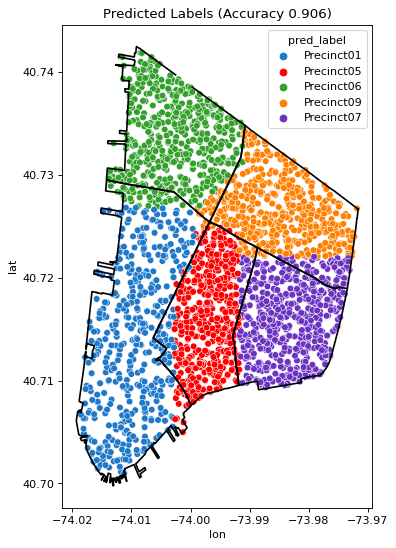

              precision    recall  f1-score   support

  Precinct01       0.93      0.88      0.90       500
  Precinct05       0.92      0.87      0.89       500
  Precinct06       0.93      0.96      0.94       500
  Precinct07       0.85      0.97      0.91       500
  Precinct09       0.91      0.85      0.88       500

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500



In [ ]:
fit_dt_int(max_depth = 4)

---

### &diams; Exercise 10

What has changed about the boundaries being created by the model (particularly evident with small `max_depth` values), what shape do they have? Does this improve model performance?

*Most are still N/S or E/W but there are some limited diagonal boundaries, this does not appear to actually improve performance however.*

---

### &diams; Exercise 11

For either model, for what values of `max_depth` do you start seeing clear evidence of overfitting?

*Around `max_depth=5` there start to be individual points that get classified.* 

---

### 3.2.2 `RandomForestClassifier`

As discussed in lecture, this class of model is an extension of the decision tree frame work whereby a number decision tree models are fit to random sub-sample (i.e. bootstrap sample) of the features. When making predictions each tree predicts a label and the most common label across all of the trees is used as the final prediction. For now we will just examine the effect of `n_estimators` which corresponds to the number of trees and `max_depth` which is the maximum depth of the trees.

In [ ]:
def fit_rf(n_estimators, max_depth):
    m_rf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth
    ).fit(X,y)
    
    model_test_assess(m_rf)

Use the following code chunk to explore the effect of different values of `max_depth` and `n_estimators` on the model's performance.

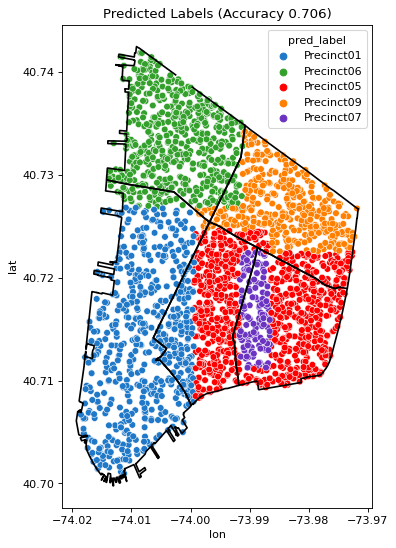

              precision    recall  f1-score   support

  Precinct01       0.77      0.91      0.84       500
  Precinct05       0.40      0.67      0.50       500
  Precinct06       0.89      0.99      0.93       500
  Precinct07       0.85      0.25      0.39       500
  Precinct09       0.95      0.71      0.81       500

    accuracy                           0.71      2500
   macro avg       0.77      0.71      0.70      2500
weighted avg       0.77      0.71      0.70      2500



In [ ]:
fit_rf(n_estimators = 5, max_depth = 3)

---

### &diams; Exercise 12

Which combination of `n_estimators` and `max_depth` seems to produce the best model performance? How does it compare to the other models considered.

In [ ]:
# Again not necessary
gs_rf = sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.RandomForestClassifier(),
    {
        "n_estimators": range(1,21),
        "max_depth": range(1,8)
    },
    cv = sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)
).fit(X,y)

In [ ]:
print( gs_rf.best_params_ )
print( gs_rf.best_score_ )

{'max_depth': 6, 'n_estimators': 15}
0.9261061946902656


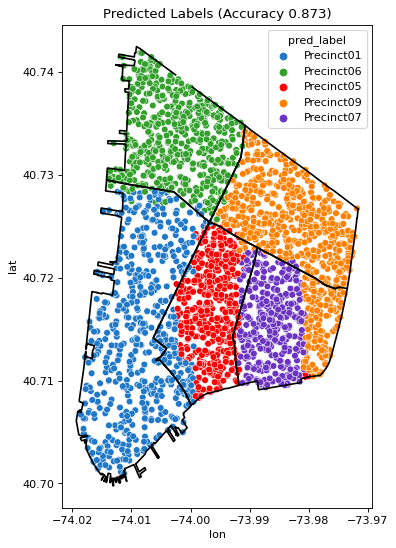

              precision    recall  f1-score   support

  Precinct01       0.85      0.96      0.90       500
  Precinct05       0.95      0.78      0.85       500
  Precinct06       0.96      0.99      0.98       500
  Precinct07       0.94      0.66      0.78       500
  Precinct09       0.75      0.97      0.84       500

    accuracy                           0.87      2500
   macro avg       0.89      0.87      0.87      2500
weighted avg       0.89      0.87      0.87      2500



In [ ]:
fit_rf(n_estimators = 8, max_depth = 7)

*Peformance seems slightly worse than some of the other models considered. Other values of `n_estimators` and `max_depth` produce very similar results.*

---

### &diams; Exercise 13

For a given `max_depth` (e.g. 4) compare the performance of a single decision tree model to random forrest models with different values of `n_estimators`, how do they compare?

In [ ]:
sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.RandomForestClassifier(),
    {
        "n_estimators": range(1,11),
        "max_depth": [4]
    },
    cv = sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)
).fit(
    X,y
).cv_results_["mean_test_score"]

array([0.82433628, 0.86504425, 0.88761062, 0.90575221, 0.89513274,
       0.89823009, 0.90132743, 0.90132743, 0.9039823 , 0.90265487])

*We can see that the accuracy inproves as `n_estimators` increases but is seems to plateau around 3 or more.*

---

### &diams; Exercise 14

Do you think the inclusion of an interaction feature would help or hurt this model's performance? Explain.

*Based on the previous results with the `DecisionTreeClassifier` I would not expect that the performance would improve significantly.*

## 3.3 Comparisons



### &diams; Exercise 15

You have now been given the opportunity to experiment with a number of different multiclass classification models. Based on your experience with this data set which model do you think is best for this particular classification task? Justify your answer.

You answer should contain some discussion of the potential for overfitting.

*Answers will vary - generally my preference would be for the multinomial model as it has equavalent performance to the others while having superior interpretability.*

---

## 4. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF and turn it in on gradescope under the `mlp-week09` assignment.

In [ ]:
!jupyter nbconvert --to pdf mlp-week09.ipynb

[NbConvertApp] Converting notebook mlp-week09.ipynb to pdf
[NbConvertApp] Support files will be in mlp-week09_files/
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Making directory ./mlp-week09_files
[NbConvertApp] Writing 84759 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a763133b-df06-4ae6-8e64-f595cb550d96' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>